# ACETONE tutorial #2

**Implementing and using other versions of a layer**

Efficiency is a key aspect in the embedded sector, with each code being specifically adpated to a terget. As such, we need to be able to chose the implementation of each layer.

In this notebook, we'll explain how to create and use specific versions of a layer in ACETONE.

* When running this notebook on Colab, we need to install ACETONE 
* If you run this notebook locally, run it in the environment in which you installed ACETONE

In [1]:
# TODO Installs on collab

In [2]:
# Cleaning the working environment
from pathlib import Path
from os import remove, listdir

def clean_working_directory(directories):
    for directory in directories:
        if directory.exists():
            for file in listdir(directory):
                if not (directory / file).is_dir():
                    remove(directory / file)

# Path to the example files
PATH_DIR = Path("../tests/models/lenet5/lenet5_trained")

# Path to generated directories
loops_output_path = Path("demo_lenet_6loops")
indirect_gemm_output_path = Path("demo_lenet_indirect_gemm")
std_gemm_output_path = Path("demo_lenet_std_gemm")
demo_output_path = Path("demo_lenet_optimized")

files_directories = [loops_output_path, indirect_gemm_output_path, std_gemm_output_path, demo_output_path]

clean_working_directory(files_directories)

## Imports

In this notebook, we'll use as an example a simple Lenet5 model exported to Keras' format h5. The used dataset is randomly generated for testing purposes.

![lenet5](./data/lenet5_trained.png)

In [3]:
# External imports
import numpy as np
import pystache

import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)

# ACETONE's imports
from acetone_nnet import CodeGenerator, cli_compare, list_all_implementations, conv2d_factory
from acetone_nnet.generator import Conv2D

2025-05-11 14:18:54.893203: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 14:18:54.899479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-11 14:18:54.984705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-11 14:18:54.986694: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 14:18:55.927536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [4]:
# Path to the model
model_path = PATH_DIR / "lenet5_trained.h5"
model = keras.models.load_model(model_path)
model.compile("adam", "categorical_crossentropy", metrics=["acc"])
# Path to the input file
dataset = PATH_DIR / "test_input_lenet5.txt"
dataset = "./input.txt"
# Function name
function_name = "demo_lenet"
# Number of test
nb_tests = 1

In [5]:
def write_input(inputs, nb_tests, tempdir_name):
    if nb_tests > len(inputs):
        raise ValueError(f"Can't have more tests to write ({nb_tests}) than values ({len(inputs)})")
    with open(tempdir_name / "input.txt" , "w+") as fi:
        for i in range(nb_tests):
            x = inputs[i]
            print("[",end="",file=fi)
            out_string = ",".join(
                [f'"{float(n).hex().replace("0000000p", "p")}"' for n in x],
            )
            print(f"{out_string}", end="", file=fi, flush=True)
            print("]", file=fi)


def extract_outputs_c(
        path_to_output: str | Path,
        nb_tests: int,
) -> np.ndarray:
    """Get the outputs values from the txt file."""
    output = []
    with Path.open(Path(path_to_output)) as f:
        for i, line in enumerate(f):

            line = line[:-2].split(" ")
            line = list(map(float.fromhex, line))
            line = np.array(line)
            
            output.append(line)
            
            if i >= nb_tests:
                break
    f.close()
    return line

data =  np.random.default_rng(10).random((1,28*28), dtype=np.float32)
write_input(data,1,Path("."))


In [6]:
img_rows, img_cols = 28, 28
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255.0
x_test /= 255.0
y_train = keras.utils.to_categorical(y_train_)
y_test = keras.utils.to_categorical(y_test_)

x_train = np.array([x.reshape((28,28)) for x in x_train])
x_test = np.array([x.reshape((28,28)) for x in x_test])

In [7]:
model.fit(x_train, y_train, batch_size=32, shuffle=True, validation_split=0.2, epochs=3)
model.evaluate(x_test, y_test, batch_size=32)

Epoch 1/3
1500/1500 [==============================] - 19s 12ms/step - loss: 0.0194 - acc: 0.9931 - val_loss: 0.0198 - val_acc: 0.9930
Epoch 2/3
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0166 - acc: 0.9946 - val_loss: 0.0236 - val_acc: 0.9919
Epoch 3/3
313/313 [==============================] - 3s 8ms/step - loss: 0.0534 - acc: 0.9852


[0.05340440571308136, 0.9851999878883362]

## Using ACETONE's native implementations

The framework laready provides, for some layers, several versions from which to choose before generating our code.

In [8]:
implemented = list_all_implementations()
for layer_name in implemented:
    print(layer_name,":")
    for implementation in implemented[layer_name]:
        print("   ", implementation)
    print("\n")

Conv2D :
    6loops
    indirect_gemm_nn
    indirect_gemm_tn
    indirect_gemm_nt
    indirect_gemm_tt
    std_gemm_nn
    std_gemm_tn
    std_gemm_nt
    std_gemm_tt
    gemm_target




# Version of the layer to use
conv_algorithm = "indirect_gemm_nn"

# Create an ACETONE CodeGenerator from the model

Let's focus on the convolution layer.

The 3 main algorithms provided by ACETONE for the convolution are: *6loops*, *std_gemm* and *indirect_gemm*.

The first algorithm implements the naive version of a convolution: a triple loop iters all the indices of the ouput, and for each of this indices another triple loop compute the value using the input tensor and the kernel, as illustrated below (for a 2D exemple).

![Conv_6loops](./data/conv_6loops.gif "segment")

We can change the implementation of a specific type of layer by using the class **CodeGenerator**'s argument `versions`.
This argument takes a dictionary containing a reference to the layer (usually the name) as key and the version's name as value.

In [9]:
# Create an ACETONE CodeGenerator from the model
loops_generator = CodeGenerator(file=model,
                                function_name=function_name,
                                external_input=True,
                                versions={"Conv2D":"6loops"},
                                nb_tests=nb_tests)

Finished model initialization.


In [10]:
loops_generator.generate_c_files(loops_output_path)
loops_generator.compute_inference(loops_output_path, dataset_or_path=dataset)

Generated function source file.
Generated function header file.
Generated globalvars .c file.
Generated main file.
Generated Makefile.
Generated test_dataset files.
(1, 5, 5, 6)
(6, 5, 5, 16)
File output_python.txt generated.


array([6.73977828e-07, 5.35690421e-09, 1.47438710e-03, 9.97138802e-01,
       1.47134587e-10, 2.45527735e-07, 1.03531962e-10, 1.46112224e-07,
       1.38547416e-03, 2.65109776e-07])

The second algorithm, *std_gemm*, uses the standard gemm (as the name suggests) to compute the convolution. In the generated C code, the convolution is divided in two main parts: the creation of the matrix of patches from the input then the multiplication of the resulting matrix with the kernel matrix.

![Conv_std_gemm](./data/std_gemm.png)

In [11]:
# Create an ACETONE CodeGenerator from the model
std_gemm_generator = CodeGenerator(file=model,
                                    function_name=function_name,
                                    external_input=True,
                                    versions={"Conv2D":"std_gemm_nn"},
                                    nb_tests=nb_tests)

Finished model initialization.


In [12]:
std_gemm_generator.generate_c_files(std_gemm_output_path)
std_gemm_generator.compute_inference(std_gemm_output_path, dataset_or_path=dataset)

Generated function source file.
Generated function header file.
Generated globalvars .c file.
Generated main file.
Generated Makefile.
Generated test_dataset files.
(1, 5, 5, 6)
(6, 5, 5, 16)
File output_python.txt generated.


array([6.73977828e-07, 5.35690421e-09, 1.47438710e-03, 9.97138802e-01,
       1.47134587e-10, 2.45527735e-07, 1.03531962e-10, 1.46112224e-07,
       1.38547416e-03, 2.65109776e-07])

The third algorithm is another implementation of the gemm algorithm. Instead of computing the patches matrix during the execution inf the C code, the framework computes before the generation and add to the code a matrix of pointers, each refering to the corresponding element in the input tensor.

![Conv_indirect_gemm](./data/indirect_gemm.png)

In [13]:
# Create an ACETONE CodeGenerator from the model
indirect_gemm_generator = CodeGenerator(file=model,
                                            function_name=function_name,
                                            external_input=True,
                                            versions={"Conv2D":"indirect_gemm_nn"},
                                            nb_tests=nb_tests)

Finished model initialization.


In [14]:
indirect_gemm_generator.generate_c_files(indirect_gemm_output_path)
indirect_gemm_generator.compute_inference(indirect_gemm_output_path, dataset_or_path=dataset)

Generated function source file.
Generated function header file.
Conv2D 1 patches size: (14400,)
Conv2D 3 patches size: (9600,)
Generated globalvars .c file.
Generated main file.
Generated Makefile.
Generated test_dataset files.
(1, 5, 5, 6)
(6, 5, 5, 16)
File output_python.txt generated.


array([6.73977828e-07, 5.35690421e-09, 1.47438710e-03, 9.97138802e-01,
       1.47134587e-10, 2.45527735e-07, 1.03531962e-10, 1.46112224e-07,
       1.38547416e-03, 2.65109776e-07])

We can now compile and run those generated code to ensure that the semantic was indeed preserved.

In [15]:
# Compiling the code
! make -C demo_lenet_indirect_gemm all

# Running the executable
! ./demo_lenet_indirect_gemm/demo_lenet ./demo_lenet_indirect_gemm/output_c.txt ../tests/models/lenet5/lenet5_trained/test_input_lenet5.txt

make: Entering directory '/home/yaitaissa/Documents/onera/acetone/tutorials/demo_lenet_indirect_gemm'
gcc -g -w -lm   -c -o inference.o inference.c
gcc -g -w -lm   -c -o global_vars.o global_vars.c
gcc -g -w -lm   -c -o main.o main.c
gcc   -o demo_lenet inference.o global_vars.o main.o inference.h test_dataset.h  -g -w -lm
make: Leaving directory '/home/yaitaissa/Documents/onera/acetone/tutorials/demo_lenet_indirect_gemm'
   Average time over 1 tests: 2.564000e-05 s 
   ACETONE framework's inference output: 
1.32341302e-06 0.0977965146 0.00754283788 0.00250191917 2.29646739e-05 0.15008527 3.39264807e-06 0.741994202 7.77348763e-09 5.15184147e-05 


In [16]:
# Compiling the code
! make -C demo_lenet_std_gemm all

# Running the executable
! ./demo_lenet_std_gemm/demo_lenet ./demo_lenet_std_gemm/output_c.txt ../tests/models/lenet5/lenet5_trained/test_input_lenet5.txt

make: Entering directory '/home/yaitaissa/Documents/onera/acetone/tutorials/demo_lenet_std_gemm'
gcc -g -w -lm   -c -o inference.o inference.c
gcc -g -w -lm   -c -o global_vars.o global_vars.c
gcc -g -w -lm   -c -o main.o main.c
gcc   -o demo_lenet inference.o global_vars.o main.o inference.h test_dataset.h  -g -w -lm
make: Leaving directory '/home/yaitaissa/Documents/onera/acetone/tutorials/demo_lenet_std_gemm'
   Average time over 1 tests: 3.037000e-05 s 
   ACETONE framework's inference output: 
1.32341302e-06 0.0977965146 0.00754283788 0.00250191917 2.29646739e-05 0.15008527 3.39264807e-06 0.741994202 7.77348763e-09 5.15184147e-05 


In [17]:
cli_compare(reference_file=(indirect_gemm_output_path / "output_c.txt"), c_file=(std_gemm_output_path / "output_c.txt"), nb_tests=1)

    Max absolute error for 1 test(s): 0.0
    Max relative error for 1 test(s): 0.0



## Adding a new implementation

Let's now assume that, after studies and tests, we have found a new way to perform a convolution : setting each element of the output to `0.42`.

This method being far more efficient and simple than any other, we want to use it with ACETONE. But, sadly, the framework doesn't have an implementation for it, we have to add it ourselves.

In [18]:
# Printing all the algorithm implemented in ACETONE for a convolution
print("Base implementations : ")
print(conv2d_factory.list_implementations)

Base implementations : 
['6loops', 'indirect_gemm_nn', 'indirect_gemm_tn', 'indirect_gemm_nt', 'indirect_gemm_tt', 'std_gemm_nn', 'std_gemm_tn', 'std_gemm_nt', 'std_gemm_tt', 'gemm_target']


To implement it, we have to  create a new class inheriting from the `Conv2D` class (or one of its child classes). 

* The first method we must implement is called `generate_inference_code`. This method will construct the C code correponding to the layer, and return it as a string.
* The second method, `forwad_path_layer`, is optional. It tell the framework how to compute the output of the layer unsing Pyhton. If not given, the method defined in the parent class is used.



In [19]:
# Creating a new implementation
class Conv2D_Demo(Conv2D):

    def __init__(self, **kwargs: int) -> None:
        """Build a Convolution layer with a demo implementation."""
        super().__init__(**kwargs)
    
    def generate_inference_code_layer(self) -> str:
        """Generate computation code for layer."""
        input_str = [prev_layer.output_str for prev_layer in self.previous_layer]
        ouptut_str = f"output_{self.path}"

        code_str =  "    // {{name}}_{{idx}}\n    for (k = 0; k < {{size}}; ++k) {{output_str}}[k] = 0.42;"
        return pystache.render(code_str,{"name":self.name, "idx":self.idx, "size":self.size,"output_str":ouptut_str})
    
    def forward_path_layer(self, input_array) -> np.ndarray:
        return 0.42*np.ones((1,self.output_channels,self.output_height,self.output_width))

When parsing the neural network, each time ACETONE encounters a layer having several versions, it places a temporary layers. Once the model completly extracted, those placeholders are then replaced by a defintive layer whith the correct implementation, simply by extracting the values stored (such as weight, size, biases, ...) and using them to initialize a new layer.

In [20]:
# Creating a Conv2D_Demo layer using the attributes of old_layer
def conv2d_demo_implementation(
        old_layer: Conv2D,
        conv_algo: str,
) -> Conv2D_Demo:
    return Conv2D_Demo(
        idx=old_layer.idx,
        conv_algorithm=conv_algo,
        size=old_layer.size,
        padding=old_layer.padding,
        strides=old_layer.strides,
        kernel_h=old_layer.kernel_h,
        kernel_w=old_layer.kernel_w,
        dilation_rate=old_layer.dilation_rate,
        nb_filters=old_layer.nb_filters,
        input_shape=[1, old_layer.input_channels, old_layer.input_height, old_layer.input_width],
        output_shape=[1, old_layer.output_channels, old_layer.output_height, old_layer.output_width],
        weights=old_layer.weights,
        biases=old_layer.biases,
        activation_function=old_layer.activation_function,
    )

Finally, to add the newly created implementation to ACETONE, we need to register it within the layer's version manager.

In [21]:
conv2d_factory.register_implementation("demo", conv2d_demo_implementation)

print("Updated implementations : ")
print(conv2d_factory.list_implementations)

Updated implementations : 
['6loops', 'indirect_gemm_nn', 'indirect_gemm_tn', 'indirect_gemm_nt', 'indirect_gemm_tt', 'std_gemm_nn', 'std_gemm_tn', 'std_gemm_nt', 'std_gemm_tt', 'gemm_target', 'demo']


The new version being available in the list of implementations, we can now use it to generate code.

In [22]:
# Create an ACETONE CodeGenerator from the model
demo_generator = CodeGenerator(file=model,
                                    function_name=function_name,
                                    external_input=True,
                                    versions={"Conv2D":"demo"},
                                    nb_tests=nb_tests)

demo_generator.generate_c_files(demo_output_path)

Finished model initialization.
Generated function source file.
Generated function header file.
Generated globalvars .c file.
Generated main file.
Generated Makefile.
Generated test_dataset files.


The code then has the optimized implementation and is ready to be deployed on any target !

# Study Case

Comparing the outputs of a random dataset is great for tests, but not really demonstratif and adapted to a tutorial like this one. 

To illustrate the conservation of semantics between the different versions seen, we'll use the MNIST dataset.

## Loading images

We first load MNIST data from keras dataset

[ 352 5990 1177 8034 3314 3639 4210 1298 7576  843]
1/1 [==============================] - 0s 41ms/step
   Average time over 1 tests: 2.549000e-05 s 
   ACETONE framework's inference output: 
1.32341302e-06 0.0977965146 0.00754283788 0.00250191917 2.29646739e-05 0.15008527 3.39264807e-06 0.741994202 7.77348763e-09 5.15184147e-05 
[1.32341302e-06 9.77965146e-02 7.54283788e-03 2.50191917e-03
 2.29646739e-05 1.50085270e-01 3.39264807e-06 7.41994202e-01
 7.77348763e-09 5.15184147e-05] 7
   Average time over 1 tests: 4.213000e-05 s 
   ACETONE framework's inference output: 
1.32341302e-06 0.0977965146 0.00754283788 0.00250191917 2.29646739e-05 0.15008527 3.39264807e-06 0.741994202 7.77348763e-09 5.15184147e-05 
[1.32341302e-06 9.77965146e-02 7.54283788e-03 2.50191917e-03
 2.29646739e-05 1.50085270e-01 3.39264807e-06 7.41994202e-01
 7.77348763e-09 5.15184147e-05] 7
   Average time over 1 tests: 3.827000e-05 s 
   ACETONE framework's inference output: 
1.32341302e-06 0.0977965146 0.0075428378

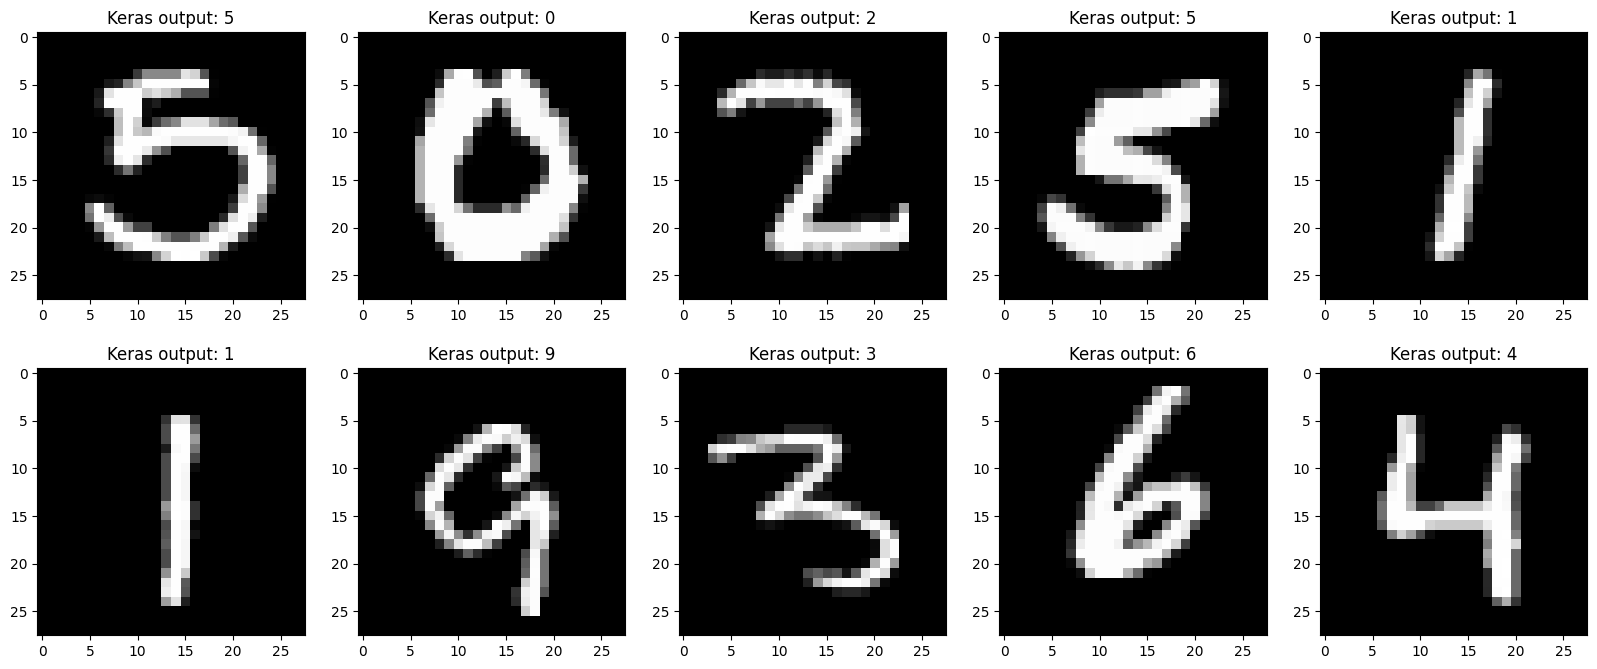

In [ ]:
n_col = 5
n_row = 2
n_samples = n_col*n_row
indexes = np.random.permutation(len(x_test))[:n_samples]
print(indexes)

inputs = x_test[indexes]
keras_ouputs = model.predict(inputs)
keras_labels = keras_ouputs.argmax(axis=-1)

std_gemm_labels = []
for x in inputs: 
    write_input([x.flatten()], 1, Path("."))
    ! ./demo_lenet_std_gemm/demo_lenet ./demo_lenet_std_gemm/output_c.txt ./input.txt
    labels = extract_outputs_c("./demo_lenet_std_gemm/output_c.txt",1)
    print(labels, labels.argmax(axis=-1))
    std_gemm_labels.append(labels.argmax())



fig,axs = plt.subplots(n_row,n_col)

for i in range(n_row):
    for j in range(n_col):
        ax = axs[i,j]
        ax.imshow(inputs[i*n_col+j], cmap="gray")
        ax.set_title(f"Keras output: {keras_labels[i*n_col+j]}")

print(std_gemm_labels)
        